# Recommendation System For Top 5 Movies

## Group-4 Phase-4 Project

### Authors:
1. Hellen Mwaniki
2. Jesicah Mutiso
3. Endalkachew Dessalegne
4. Brian Waweru
   

## 1. Project Overview

A new movie streaming startup, aims to offer a highly personalized viewing experience to differentiate itself in a crowded market. One of its core features is a movie recommendation system that helps users discover films they are likely to enjoy, based on their past preferences. To achieve this, the system uses both collaborative filtering and content-based filtering techniques, as well as hybrid CF-CBF recommendation model, to recommend the top 5 movies tailored to each user's preferences, whether they’re long-time users or just getting started.

## 1.1. Business Understanding 
### 1.1.1 Business Problem 


In a highly competitive streaming market, retaining users is vital. The ability to accurately suggest content plays a huge role in user engagement. The company wants to implement a recommendation system that can:

- Recommend Top 5 movies to returning users who have rated other movies.

- Recommend Top 5 movies to new users with no past activity.

These two problems reflect common industry challenges:

- Personalization for known users

- Cold Start handling for new users

### 1.1.2. Objectives

- Boost engagement by offering tailored movie suggestions.

- Increase user retention through consistent, relevant recommendations.

- Solve the "cold start" problem for new users with no ratings.

## 2. Data Understanding

In [74]:
#import libraries which are necessary for the project

import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
from surprise.model_selection import train_test_split as surprise_split 
from sklearn.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1. Load Dataset

In [50]:
# load movies dataset
df_movies = pd.read_csv("data/movies.csv")
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [51]:
#load ratings dataset
df_ratings = pd.read_csv("data/ratings.csv") 
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [52]:
#shape of df_movies and ddf_ratings
print(f"Movies_df: {df_movies.shape}")
print(f"Rating_df: {df_ratings.shape}")

Movies_df: (9742, 3)
Rating_df: (100836, 4)


In [53]:
#merge movies and ratings dataset
df = df_ratings.merge(df_movies, on="movieId")
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [54]:
#shape of merged df
print(f"Shape of df: {df.shape}")

Shape of df: (100836, 6)


In [55]:
# check description of data
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [56]:
# Mean, Median and Mode of the ratings in the df_ratings
print(f"Mode of rating: {df['rating'].mode()}")
print(f"Mean of rating: {df['rating'].mean()}")
print(f"Median of rating: {df['rating'].median()}")

Mode of rating: 0    4.0
dtype: float64
Mean of rating: 3.501556983616962
Median of rating: 3.5


### 2.2. Missing values and data types

In [57]:
# check datatypes and null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


* There are no missing values in the dataset

In [58]:
# check duplicates in the dataset
print(f"Number of duplicates in the dataset:  {df.duplicated().sum()}")

Number of duplicates in the dataset:  0


## 3. Exploratory Data Analysis

### 3.1. Nmber of Movies, Ratings and Users

* Number of movies, ratings and users in the datasets
* Average number of ratings per user
* Average number of ratings per movie

In [59]:
# number of ratings of movies 
n_ratings = len(df_ratings) 
# number of movies 
n_movies = df_ratings['movieId'].nunique()
# number of users 
n_users = df_ratings['userId'].nunique() 

print(f"Number of ratings: {n_ratings}")
print(f"Number of movies: {n_movies}") 
print(f"Number of users: {n_users}") 
print()
# Average number of ratings per user & per movie
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}") 
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of movies: 9724
Number of users: 610

Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### 3.2. Distribusion of movie ratings

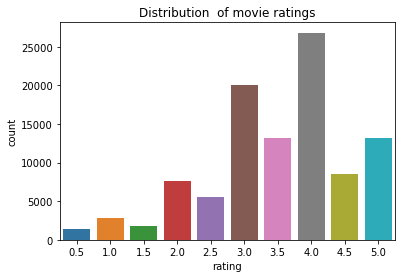

In [60]:
# plot bar graph to show distribution of movie ratings
sns.countplot(x='rating', data=df_ratings) 
plt.title("Distribution  of movie ratings") 
plt.show()

* Rating = 4 is the most frequent rating

In [61]:
print(f"Mean of ratings: {round(df_ratings['rating'].mean(), 2)}")

Mean of ratings: 3.5


### 3.3. Movies most frequently rated

In [62]:
# most frequently rated movies in the dataset 
# Value_count the movie titles and take top 5
top_movie_ratings = df['title'].value_counts()[0:5] 
print("Most frequently rated movies:")
print(top_movie_ratings)

Most frequently rated movies:
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: title, dtype: int64


### 3.4. Genre Distribution

* Observe the distribution of the genres in the dataset

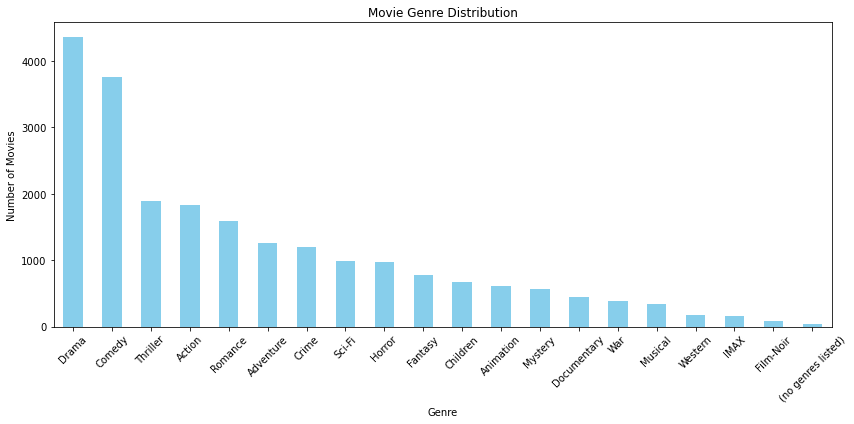

In [63]:
# Split genres and explode into individual rows
genre_split = df_movies['genres'].str.split('|')
movies_genre = df_movies.copy()
movies_genre['genres'] = genre_split
# use explode function to unpack list of genres and each item into its own row 
movies_genre = movies_genre.explode('genres')

# Count genres
genre_counts = movies_genre['genres'].value_counts()

# Plot genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Movie Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4.  Modeling 

## 4.1. Collaborative Filtering Model
* Recommend movies using collaborative filtering (CF)
* This model recommends movies for a user based on user ratings of other movies and other similar uers' ratings

In [64]:
# Prepare dataset for Surprise
reader = Reader(rating_scale=(0.5, 5)) 
#use df_ratings as dataset
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

In [65]:
# we split the dataset to trainset and testset 
trainset, testset = surprise_split(data, test_size=0.2)

# Train SVD model-instantiate and fit trainset data
svd_model = SVD() 
svd_model.fit(trainset)

### 4.1.1. Recommendation of top 5 movies for a user

In [66]:
# define a function for recommendation of top 5 movies for a user using the trained model

def cf_recommendations(userId, num_recommendations=5):
    #predict ratings by a user for movies and extract the estimated rating(.est)
    predictions = [svd_model.predict(userId, movieId).est for movieId in df_movies["movieId"]]
    
    #add 'predicted_rating' column to df_movies
    df_movies["predicted_rating"] = predictions 
    
    #sort by predicted rating in descending order and top 5 are selected.
    recommendations = df_movies.sort_values("predicted_rating", ascending=False).head(num_recommendations)

    #returm recommended movies - titles and genres
    return recommendations[["title", "genres"]]
 
# print recommended movies for a user as an example of model usage
print(cf_recommendations(userId=10))

                                                  title  \
224           Star Wars: Episode IV - A New Hope (1977)   
2743  For a Few Dollars More (Per qualche dollaro in...   
3638  Lord of the Rings: The Fellowship of the Ring,...   
922                      Godfather: Part II, The (1974)   
868         Wallace & Gromit: The Wrong Trousers (1993)   

                               genres  
224           Action|Adventure|Sci-Fi  
2743    Action|Drama|Thriller|Western  
3638                Adventure|Fantasy  
922                       Crime|Drama  
868   Animation|Children|Comedy|Crime  


* Above is a recommendation of top 5 movies for userId = 10, as an example

## 4.2. Content-Based Filtering Model

* To recommend similar movies for a new user based on the genre of a movie watched 
* Content-based filtering(CBF) model adresses **cold start**, when user has not rated movies yet

In [75]:
# TF-IDF vectorize the "genres" column of df_movies
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(df_movies["genres"]) 

# Store movie indices 
movie_indices = pd.Series(df_movies.index, index=df_movies["title"]).drop_duplicates()

In [68]:
#define a function that takes in a movie title as an input to return 5 similar movies
def cbf_recommendations(title, num_recommendations=5):
    
    # map movie title to its row index
    idx = movie_indices[title] 
    
    # plug idx into similarity matrix
    # Cosine similarity measures how similar two vectors are
    #Calculate scores between the TF-IDF vector of chosen movie (tfidf_matrix[idx]) 
    #and all other movies in the matrix.
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]))
    
    #sort the similarity scores in descending order (most similar first).
    #skip index 0(that's the movie itself) and take the next best matches.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    
    # extract the row indices of those top similar movies
    movie_ids = [i[0] for i in sim_scores]
    
    #return the title and genre of the top similar movies
    return df_movies.iloc[movie_ids][["title", "genres"]] 
    
# Example of model usage
print(cbf_recommendations("Toy Story (1995)"))

                                               title  \
1706                                     Antz (1998)   
2355                              Toy Story 2 (1999)   
2809  Adventures of Rocky and Bullwinkle, The (2000)   
3000                Emperor's New Groove, The (2000)   
3568                           Monsters, Inc. (2001)   

                                           genres  
1706  Adventure|Animation|Children|Comedy|Fantasy  
2355  Adventure|Animation|Children|Comedy|Fantasy  
2809  Adventure|Animation|Children|Comedy|Fantasy  
3000  Adventure|Animation|Children|Comedy|Fantasy  
3568  Adventure|Animation|Children|Comedy|Fantasy  


* Above is a recommendation of top 5 movies for a user who liked "Toy Story (1995)" as an example.

## 4.3. Hybrid CF-CBF Recommendation Model 

* This recommender system combines CF and CBf models
* Can handel cold start

This recommender will: 
* Normalizes CF and CBF scores for a common scale 
* Blend the two models using a weighting factor alpha(e.g., 0.5) 
* Sort and return top 5 movie recommendations 

In [69]:
# modify cf_recommendations() to return movieId and cf_rating
# num_recommendations for both cf and Cbf is increased to 200 to blend broader set
# of candidate movies(overlap) to only return top 5

def cf_recommendations(user_id, num_recommendations=200):
    
    predictions = [svd_model.predict(user_id, movieId).est for movieId in df_movies["movieId"]]
    
    # add new column cf_score to the df_movies containing predictions.
    df_movies["cf_score"] = predictions
    
    # return only movieID and cf_score to be merged later 
    return df_movies[["movieId", "cf_score"]]


In [70]:
# modify cbf_recommendations() to return movieId and score
def cbf_recommendations(title, num_recommendations=200):
    
    # retrive the row index in TF_IDF matrix for a given movie(title)
    idx = movie_indices[title] 

    # calculate cosine similarity between the given movie and all others 
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]))

    # sort movies by similarity score (excluding the first one(the movie itself))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    
    # loops through each tuple in sim_scorestake the first element of the tuple, 
    # which is the index of the movie in the TF-IDF matrix.
    movie_ids = [i[0] for i in sim_scores]

    # extracts the second element of each tuple-similarity score
    scores = [i[1] for i in sim_scores]

    # select rows by their integer location using .iloc[].
    cbf_results = df_movies.iloc[movie_ids].copy() 

    # add a new column called "cbf_score" to cbf_result assigning score
    cbf_results["cbf_score"] = scores

    # return the the movieId and cbf_score
    return cbf_results[["movieId", "cbf_score"]]

In [71]:
# add a new function which uses inputs from cf and cbf functions
def hybrid_recommendations(user_id, title, k=5, alpha=0.5):
    # call CF function, with userId input predict 200 most similar movies by rating 
    cf_df = cf_recommendations(user_id, num_recommendations=200)
    
    # call CBF function, with title input find 200 similar movies by genre
    cbf_df = cbf_recommendations(title, num_recommendations=200)

    # merge on cf_df and cbf_df
    merged = pd.merge(cf_df, cbf_df, on="movieId", how="outer").fillna(0)

    # add new cloumn for hybrid_score _ with weighted sum, alpha=0.5,
    # gives equal weight for both scores
    merged["hybrid_score"] = alpha * merged["cf_score"] + (1 - alpha) * merged["cbf_score"]

    # Join dataframe 'merged' with df_movies based on "movieId"
    merged = pd.merge(merged, df_movies, on="movieId")

    # Sort and return top k(5) movies
    top_recommendations = merged.sort_values("hybrid_score", ascending=False).head(k)
    
    return top_recommendations[["title", "genres"]]

In [72]:
# Example of model usage
print(hybrid_recommendations(user_id=10, title="Toy Story (1995)", k=5, alpha=0.5))


                                                  title  \
3568                              Monsters, Inc. (2001)   
3194                                       Shrek (2001)   
599              Wallace & Gromit: A Close Shave (1995)   
6015  Wallace & Gromit in The Curse of the Were-Rabb...   
2355                                 Toy Story 2 (1999)   

                                                 genres  
3568        Adventure|Animation|Children|Comedy|Fantasy  
3194  Adventure|Animation|Children|Comedy|Fantasy|Ro...  
599                           Animation|Children|Comedy  
6015                Adventure|Animation|Children|Comedy  
2355        Adventure|Animation|Children|Comedy|Fantasy  


* Above is a recommendation of top 5 movies for userId=10 who liked "Toy Story (1995)", as an example.

## 5. Evaluation

### 5.1. Evaluation of CF Model on testset

* **Performance metric** Root Mean Square Error **(RMSE)** is used to evaluate the accuracy of the model.
* It uses the testset data. It evaluates the model's predicted ratings versus the actual ratings in the testset.

In [73]:
# generate predicted ratings for testset
predictions_test = svd_model.test(testset) 

# print the first three prediction results
for pred in predictions_test[:3]: 
    print(pred)
# print RMSE between the true ratings and the predicted ratings
print("RMSE:", accuracy.rmse(predictions_test))

user: 469        item: 1307       r_ui = 4.00   est = 4.01   {'was_impossible': False}
user: 332        item: 93766      r_ui = 2.00   est = 3.17   {'was_impossible': False}
user: 563        item: 74688      r_ui = 3.50   est = 3.26   {'was_impossible': False}
RMSE: 0.8854
RMSE: 0.8853722751552829


* svd_model prediction object include: **user ID**, the **item (movie) ID**, **r_ui**(the true rating if known (otherwise None)), **est**(the model's estimated rating) and details: any additional metadata (like confidence)

* A value of about 0.88 of **RMSE** shows that the model deviated by about 0.87 ratings 
from the actual ratings on a 0.5 - 5.0 ratings
* It is below 1.0 and can be considered good model performance

## 6. Conclusions 
* We implemented Collaborative Filtering(CF) using SVD from the Suprise library. It performs better for active users.
* Evaluation matrix RMSE = 0.88 for Collaborative Filtering is achieved. This is acceptable for rating prediction.
* Collaborative Filtering is ideal for personalized recommendations once the user has rated many items/movies.
* We used TF-IDf vectorization of genre for Content-Based Filtering(CBF) to recommend top N unseen movies for all users, addresses cold-start users.
* Hybrid model improves recommendation by combining the two models
 

## 7. Recommendations 
* Hyperparameter tuning for CF to improve RMSE 
* To include more features such as movie description for TF-IDf to improve the model.
* Optimize the SVD model by using different similarity measures
* Optimaize alpha to balace the right weight of CF and CBF.
* To include evaluation of overall model performance for CBF and hybrid models which was not included in this project due to time constraint.  